Implementation of blog post https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f

In [2]:
# Generative Adversarial Networks (GAN) example in PyTorch. Tested with PyTorch 0.4.1, Python 3.6.7 (Nov 2018)
# See related blog post at https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

matplotlib_is_available = True
try:
  from matplotlib import pyplot as plt
except ImportError:
  print("Will skip plotting; matplotlib is not available.")
  matplotlib_is_available = False

# Data params
data_mean = 4
data_stddev = 1.25

# ### Uncomment only one of these to define what data is actually sent to the Discriminator
#(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
#(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)
#(name, preprocess, d_input_func) = ("Data and diffs", lambda data: decorate_with_diffs(data, 1.0), lambda x: x * 2)
(name, preprocess, d_input_func) = ("Only 4 moments", lambda data: get_moments(data), lambda x: 4)

print("Using data [%s]" % (name))

Using data [Only 4 moments]


**Real Data**

In [9]:
# ##### DATA: Target data and generator input data
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

**Input**

In [10]:
def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

**Generator**

Standard Feed Forward Graph

In [11]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        return x


**Discriminator**
Feed forward NN, 2 Hidden Layer and 3 Linear Maps

In [12]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        return self.f(self.map3(x))

**Train Detector and Generator**

In [13]:
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def get_moments(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  # excess kurtosis, should be 0 for Gaussian
    final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
    return final

def decorate_with_diffs(data, exponent, remove_raw_data=False):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    if remove_raw_data:
        return torch.cat([diffs], 1)
    else:
        return torch.cat([data, diffs], 1)

def train():
    # Model parameters
    g_input_size = 1      # Random noise dimension coming into generator, per output vector
    g_hidden_size = 5     # Generator complexity
    g_output_size = 1     # Size of generated output vector
    d_input_size = 500    # Minibatch size - cardinality of distributions
    d_hidden_size = 10    # Discriminator complexity
    d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification
    minibatch_size = d_input_size

    d_learning_rate = 1e-3
    g_learning_rate = 1e-3
    sgd_momentum = 0.9

    num_epochs = 5000
    print_interval = 100
    d_steps = 20
    g_steps = 20

    dfe, dre, ge = 0, 0, 0
    d_real_data, d_fake_data, g_fake_data = None, None, None

    discriminator_activation_function = torch.sigmoid
    generator_activation_function = torch.tanh

    d_sampler = get_distribution_sampler(data_mean, data_stddev)
    gi_sampler = get_generator_input_sampler()
    G = Generator(input_size=g_input_size,
                  hidden_size=g_hidden_size,
                  output_size=g_output_size,
                  f=generator_activation_function)
    D = Discriminator(input_size=d_input_func(d_input_size),
                      hidden_size=d_hidden_size,
                      output_size=d_output_size,
                      f=discriminator_activation_function)
    criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
    d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
    g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = Variable(d_sampler(d_input_size))
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = criterion(d_real_decision, Variable(torch.ones([1])))  # ones = true
            d_real_error.backward() # compute/store gradients, but don't change params

            #  1B: Train D on fake
            d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, Variable(torch.zeros([1])))  # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

            dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            g_error = criterion(dg_fake_decision, Variable(torch.ones([1])))  # Train G to pretend it's genuine

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters
            ge = extract(g_error)[0]

        if epoch % print_interval == 0:
            print("Epoch %s: D (%s real_err, %s fake_err) G (%s err); Real Dist (%s),  Fake Dist (%s) " %
                  (epoch, dre, dfe, ge, stats(extract(d_real_data)), stats(extract(d_fake_data))))

    if matplotlib_is_available:
        print("Plotting the generated distribution...")
        values = extract(g_fake_data)
        print(" Values: %s" % (str(values)))
        plt.hist(values, bins=50)
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.title('Histogram of Generated Distribution')
        plt.grid(True)
        plt.show()

<ipython-input-13-dbc3bb750e89>:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return v.data.storage().tolist()
/usr/local/lib/python3.9/dist-packages/torch/storage.py:675: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return list(self)
/usr/local/lib/python3.9/dist-packages/torch/storage.py:649: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage 

Epoch 0: D (0.6449779272079468 real_err, 0.7580015063285828 fake_err) G (0.6334645748138428 err); Real Dist ([3.9635369411706924, 1.248933216913143]),  Fake Dist ([-0.21839384865760803, 0.028622449935282682]) 
Epoch 100: D (0.5814494490623474 real_err, 0.5661861300468445 fake_err) G (0.8089563250541687 err); Real Dist ([4.093212245892733, 1.23168353793898]),  Fake Dist ([4.322987535476685, 0.10969241424403547]) 
Epoch 200: D (0.7434783577919006 real_err, 0.7096362113952637 fake_err) G (0.6741654872894287 err); Real Dist ([4.057069631367922, 1.2655187577891036]),  Fake Dist ([9.158075954437257, 1.3386077024466345]) 
Epoch 300: D (0.6425955891609192 real_err, 0.5805995464324951 fake_err) G (0.8441081047058105 err); Real Dist ([4.138885568097233, 1.2626552986221191]),  Fake Dist ([4.770728133201599, 0.15030934794978407]) 
Epoch 400: D (0.6811633110046387 real_err, 0.6026960015296936 fake_err) G (0.7787960171699524 err); Real Dist ([3.991725901067257, 1.281633912638635]),  Fake Dist ([7.37

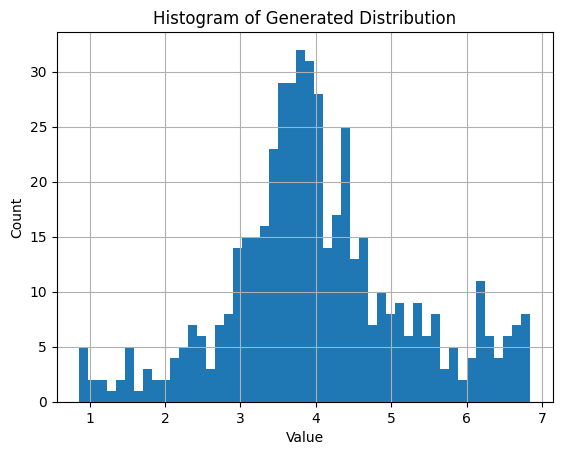

In [14]:
train()